<a href="https://colab.research.google.com/github/vs74/EEG/blob/master/Notebooks/vanilla_RNN_keras_GoogleColab_forecasting_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
rng = np.random
from array import array
from scipy import stats

#Keras import 
import keras.backend as K
from keras.models import *
from keras.layers import *

from keras import optimizers
from keras.callbacks import *

#import models
#from Linear_Regression import linear_regression 

#import datetime for tensorboard
from datetime import *

#Import for reading the MATLAB files
import glob

#Import Sckit Learn for Grid Search 
from sklearn.model_selection import GridSearchCV
#Preprocessing using scikit learn 
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [5]:
!ls

sample_data


In [0]:
#Import for Loading EEG data from Google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
#Authenticate with google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Download Single subject file from EEG
downloaded = drive.CreateFile({'id':"1bMufocvl7m34YO4JWHPb2rZtIX85TtnL"})   # replace the id with id of file you want to access
downloaded.GetContentFile('1.mat')        # replace the file name with your file

In [11]:
#Check the data is downloaded or not
!ls

1.mat  adc.json  sample_data


In [12]:
#Ensure Google COlab is utilising GPU 
tf.test.gpu_device_name()


'/device:GPU:0'

In [13]:
#Ensure that GPU memory utilisation is full
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=bd658425e80f966b02c53ec348ee747cc35d9b17cef545cce5dc802d40533dca
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.5 GB  | Proc size: 686.7 MB
GPU RAM Free: 14968MB | Used: 111MB | Util   1% | Total 15079MB


In [14]:
!ls

1.mat  adc.json  sample_data


In [15]:


# data import from matlab
subject_1 = sio.loadmat('1.mat')      #recovering matlab data in the form of a python dictionar
format_1 = subject_1['data']          #in the dictionary, only the data key interests us
print (format_1.shape)

# shuffle trials
(channel, trial, time_points)= format_1.shape

trials = np.arange(trial)
np.random.shuffle(trials)

#Z score
format_1=stats.zscore(format_1, axis=2)

(65, 192, 1000)


In [0]:
def preprocess_data(data):
    #Reshape 3d array to 2d so it get's prrocessed by scikit learn
    channel, trial, time_points = data.shape[0], data.shape[1], data.shape[2]
    data = data.reshape(channel, -1)
    
    #Min max scaler for normalizing the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data)
    normalized = scaler.transform(data)
    
    #reshape the data to 3D array again
    normalized = normalized.reshape(channel, trial, time_points)
    return normalized, scaler




In [17]:
print(type(format_1))

<class 'numpy.ndarray'>


In [0]:
format_1, scaler = preprocess_data(format_1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


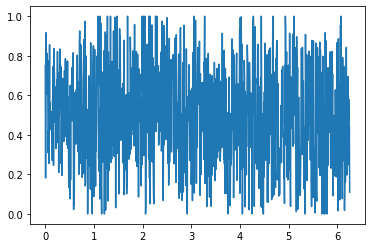

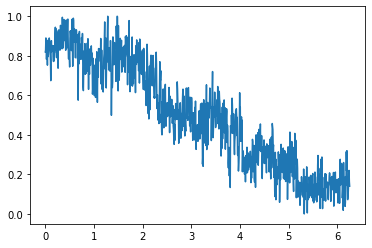

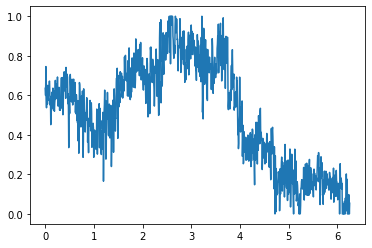

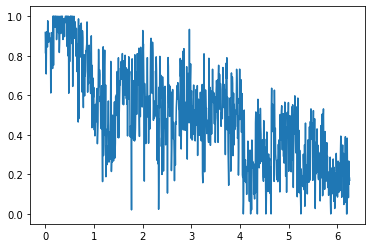

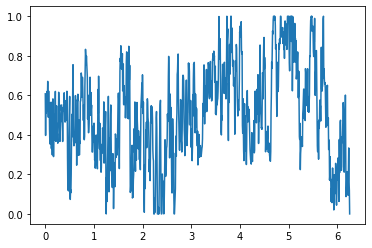

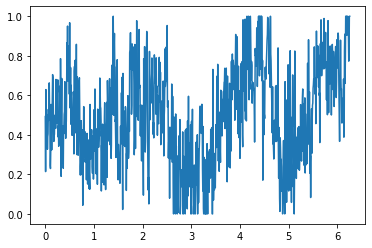

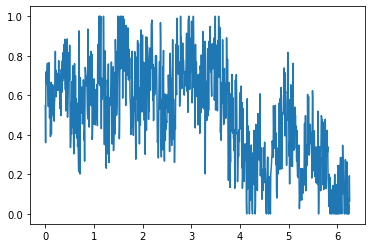

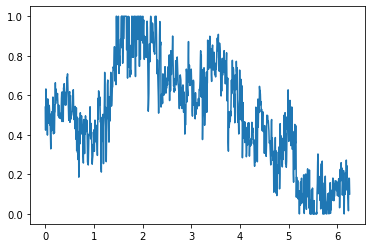

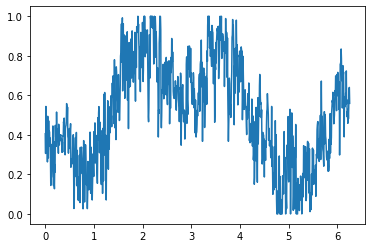

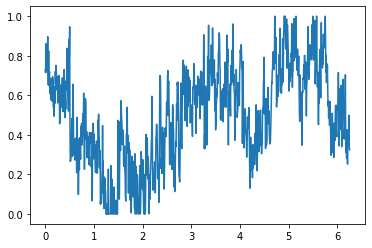

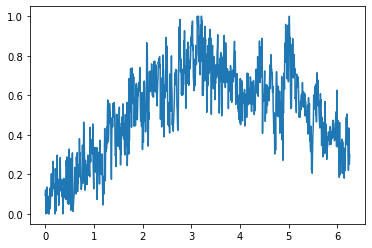

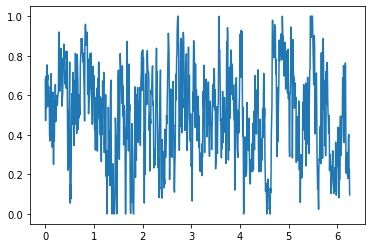

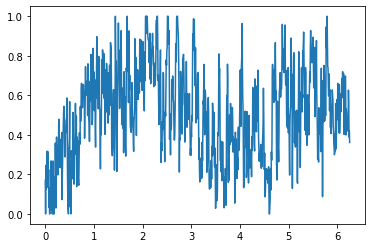

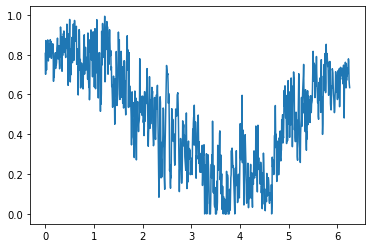

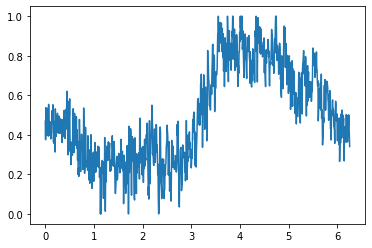

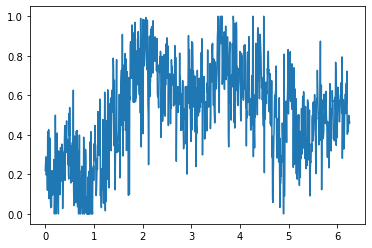

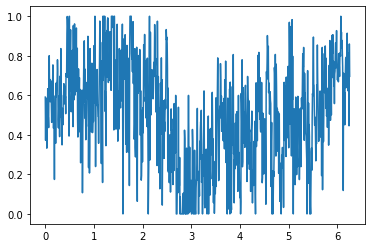

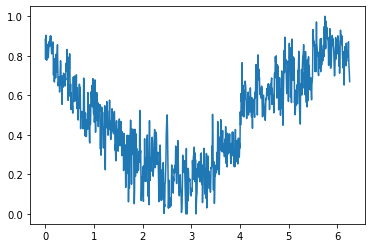

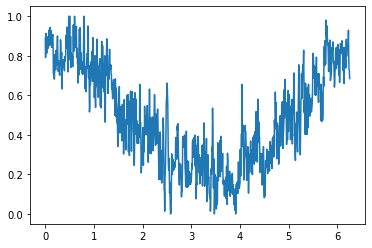

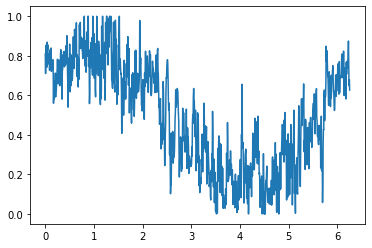

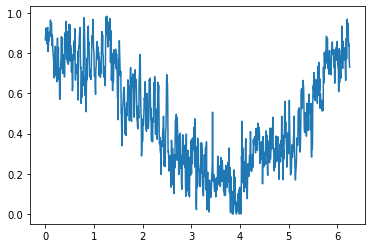

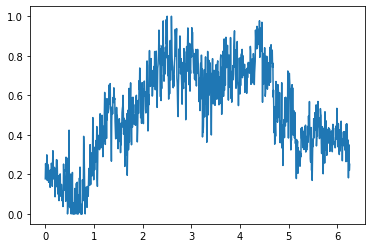

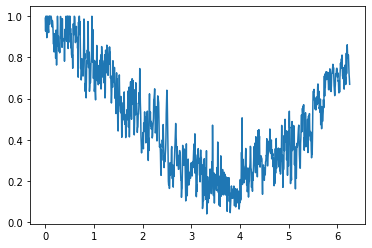

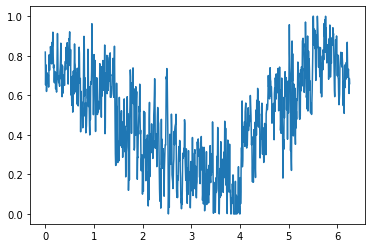

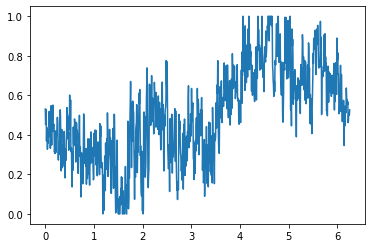

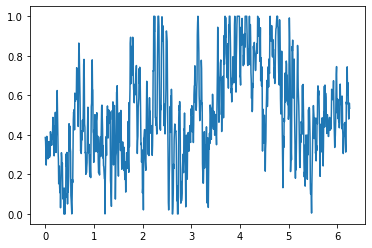

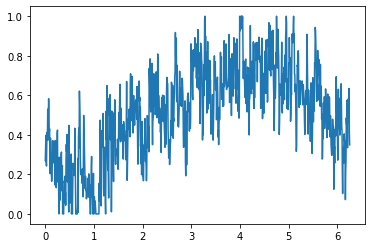

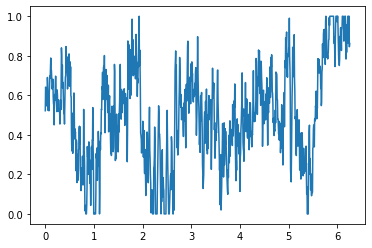

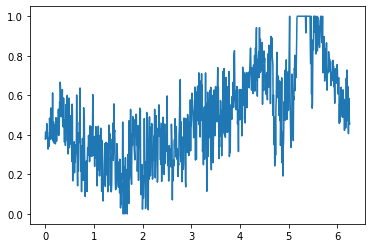

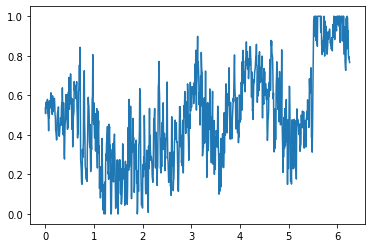

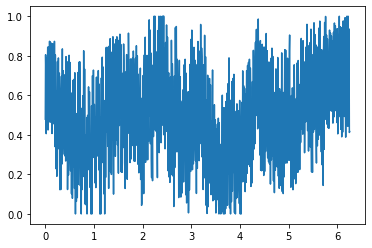

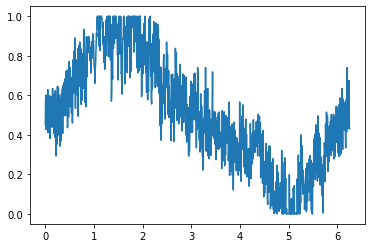

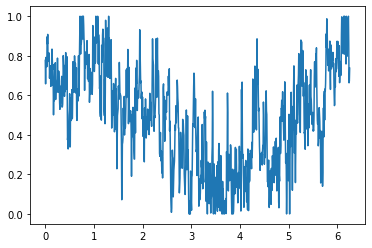

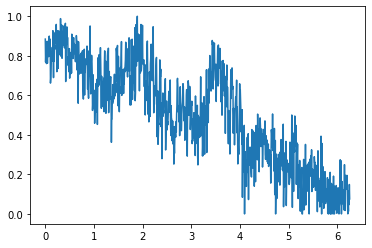

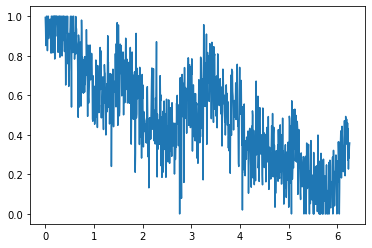

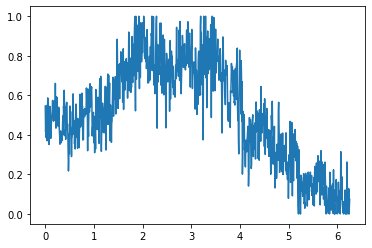

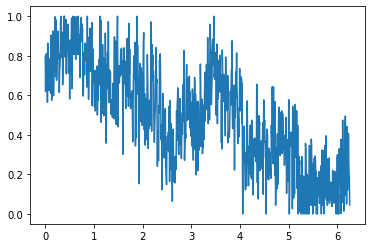

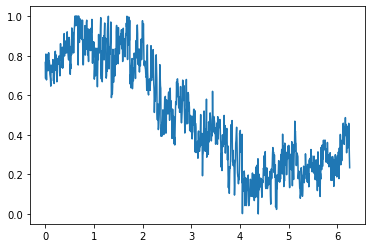

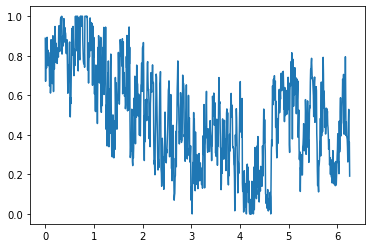

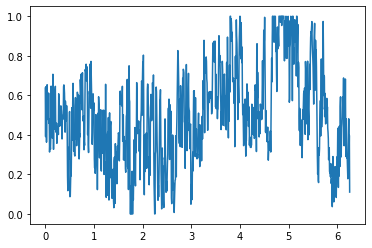

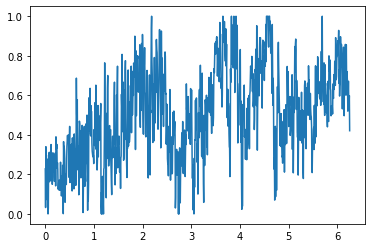

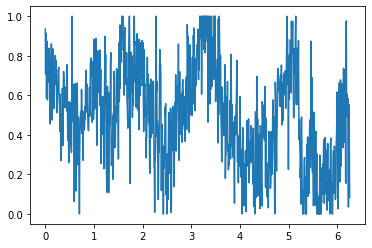

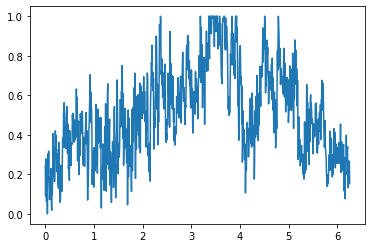

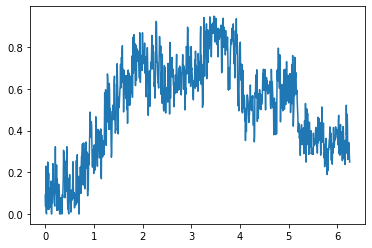

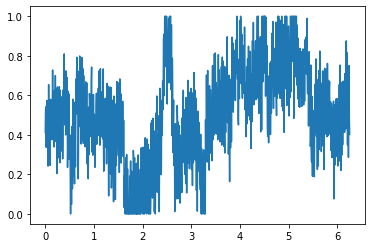

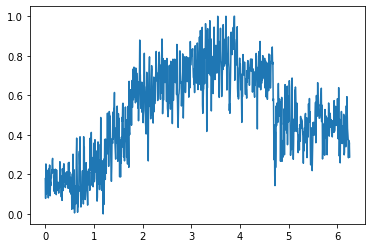

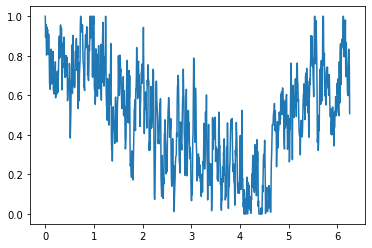

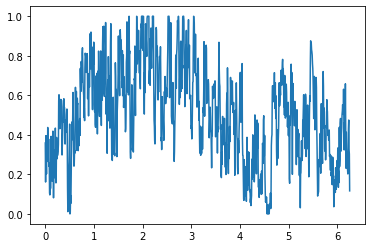

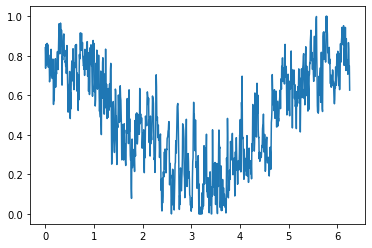

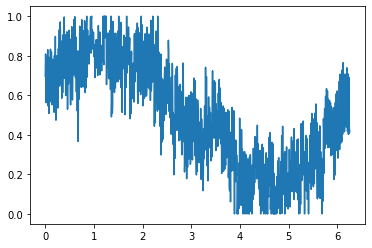

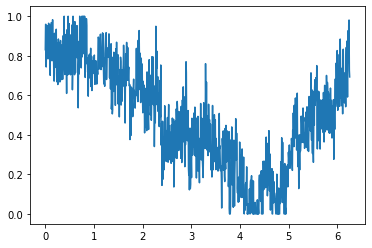

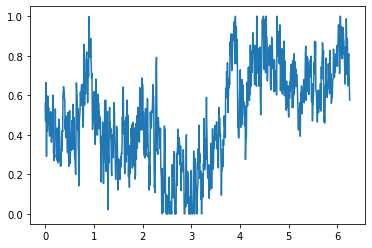

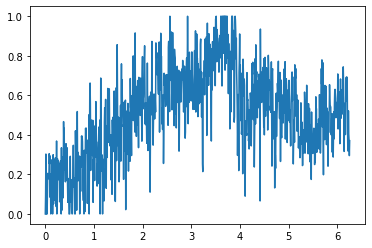

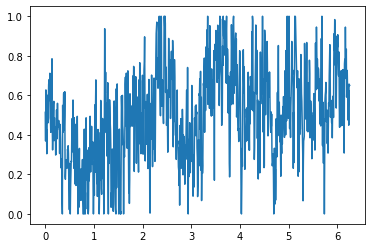

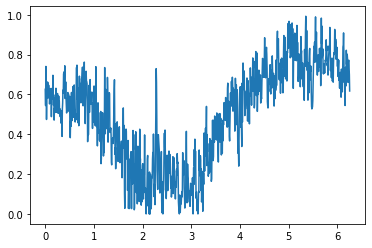

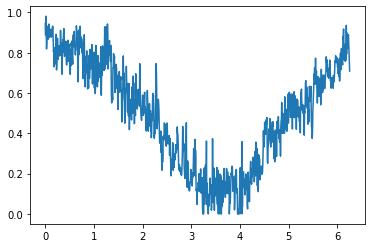

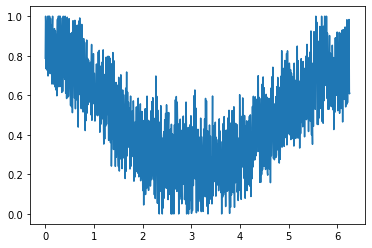

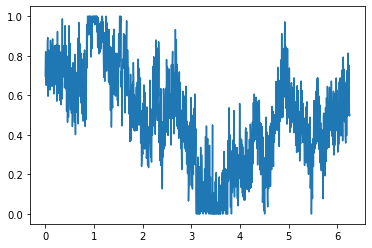

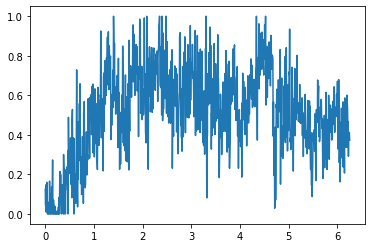

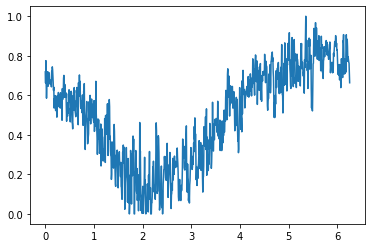

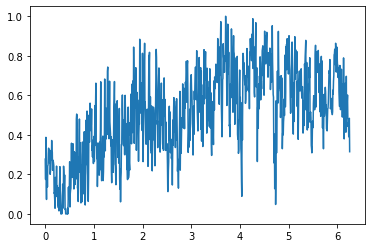

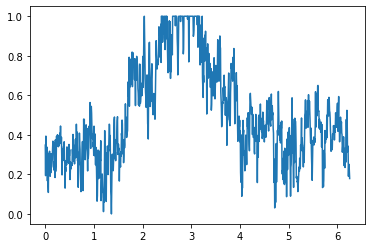

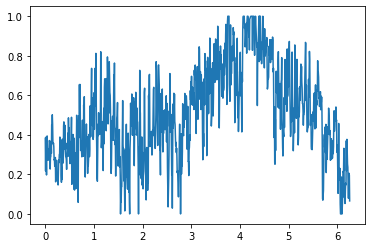

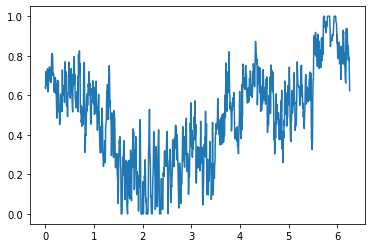

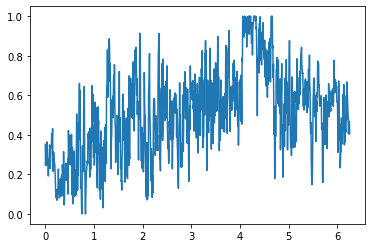

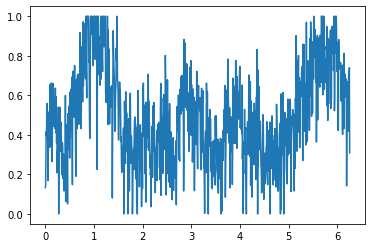

In [19]:
#Plot EEG
#plot of a single channel of EEG
%matplotlib inline
Time = np.linspace(0, 6.25, 1000)
for i in range (channel):
    plt.plot(Time, format_1[i][0])
    plt.figure()

plt.plot(Time, format_1[52][1])



In [20]:
# parametres

eltmp = input ('''Enter the electrode number:''')
electi = list(map(int, eltmp.split()))    #separation of the different responses and recovery in the form of a list of integers
print (type(electi))
print(electi)

stim = input ('''Enter the number of stimuli:''')
stim = int(stim)

relation = input('''Please define what should be predicted (1 for EEG from stimulus or 2 for stimulus from EEG or 3 for EEG forecasting ):''')

if relation == '1':
    response = input("Do you want to embed information of EEG as well ? ( 1 for yes or 2 for no)")
    if repsonse == "2":
      source_Y = electi[0]    #retrieving the electrode number as a whole number - implies that there is only one electrode chosen in this direction
      source_X = [0]          #conversion of the stimuli line in the form of a list - necessary for the for loop: see below - extraction X
    else:
      source_Y = electi[0]
      source_X = [0] + electi[0]

elif relation == '2':
    format_1 = np.flip(format_1,2)     # data inversion according to the time dimension - problem ????
    source_Y = 0
    source_X = electi
    
elif relation == '3':
    response = input("Do you want to embed information of Stimuli as well ? ( 1 for yes or 2 for no)") 
    if response == "2":
      source_Y = electi
      source_X = electi
    else: 
      source_Y = electi
      source_X = electi + [0]       

hiLaSi_tmp = input('''please specify the number of layers and neurons per desired layers: ''')
hidden_layers = list(map(int, hiLaSi_tmp.split()))
print (hidden_layers)
print (type(hidden_layers))

learning_rate = input('''enter the lambda / learning rate: ''')
learning_rate = float(learning_rate)      # conversion as a decimal number

Enter the electrode number:30
<class 'list'>
[30]
Enter the number of stimuli:160
Please define what should be predicted (1 for EEG from stimulus or 2 for stimulus from EEG or 3 for EEG forecasting ):3
Do you want to embed information of Stimuli as well ? ( 1 for yes or 2 for no)2
please specify the number of layers and neurons per desired layers: 1
[1]
<class 'list'>
enter the lambda / learning rate: 0.001


In [0]:
#### separation of train tests / valid / test

train_num = int(np.around(len(trials) * 0.8))
valid_num = int(np.around(len(trials) * 0.1))
test_num = len(trials) - train_num - valid_num

trials_train = trials[0:train_num]
trials_valid = trials[train_num:train_num+valid_num]
trials_test = trials[train_num+valid_num:]

In [22]:
# extract data from format_1

def extract_Y (batch_trials, batch_num):              #creation of a function to recover y - simplification of reading
    
    y_tmp=format_1[source_Y, batch_trials, stim:]     #recovery of Y in the form of a matrix of 154 * 840
    y_tmp=np.reshape(y_tmp, ((time_points-stim)*batch_num))    #passage through the list of 129 360 values ​​(test 0, test 1, ... test 153)
    y_tmp=np.matrix(y_tmp)                           #1 * 129360 matrix conversion
    y_tmp=np.transpose(y_tmp)                        #transposition into a matrix of 129360 * 1, matrix equal to that of Matlab (necessary for the rest)
    return y_tmp                                     #returns the content of y_tmp
    
y_train = extract_Y (trials_train, train_num)
print ("y_train.shape = ", y_train.shape)
y_valid = extract_Y (trials_valid, valid_num)
print ("y_valid.shape = ", y_valid.shape)
y_test = extract_Y (trials_test, test_num)
print ("y_test.shape = ", y_test.shape)

y_train.shape =  (129360, 1)
y_valid.shape =  (15960, 1)
y_test.shape =  (15960, 1)


In [23]:
def extract_X (batch_trials, batch_num):                     #creation of a function to recover x - simplification of reading
    x_tmp = [[]]*((time_points-stim)*batch_num)                       #creation of an empty list x_tmp of size (129630,)
    x_tmp = np.matrix(x_tmp)                                #conversion as a matrix 129630 * 0 (number of lines good)
    x_tmp = np.transpose(x_tmp)                             #transposition 1: form 0 * 129630, necessary at n.append
                                                            #avoid the transposition line in the for loop (2 transpo instead of 160
    for i in source_X:                                      #reading the source list -> reading each electrode number if flip
        k = 0
        while k < stim:                                     #160 loops - recovery of the 840 values ​​of each test (in the form test 1, test 2, ...), shifted by 1 at each iteration
            tmp = format_1[i, batch_trials, k:(time_points-stim+k)]    #see extract_Y
            tmp = np.reshape(tmp,((time_points-stim)*batch_num))
            tmp = np.matrix(tmp)
            
            x_tmp = np.append(x_tmp, tmp, axis=0)           #concatenation of the matrix tmp 1 * 129360 at the end of the matrix x_tmp (k + 1) * 129360
            k = k+1
    x_tmp = np.transpose(x_tmp)                             #transposition 2: form 129360 * (160 * nbr_électrode)
    return x_tmp
        
x_train = extract_X (trials_train, train_num)
print ("x_train.shape = ", x_train.shape)
x_valid = extract_X (trials_valid, valid_num)
print ("x_valid.shape = ", x_valid.shape)
x_test = extract_X (trials_test, test_num)
print ("x_test.shape = ", x_test.shape)

x_train.shape =  (129360, 160)
x_valid.shape =  (15960, 160)
x_test.shape =  (15960, 160)


In [24]:
#tensorflow - Linear regression cf github


train_X = x_train
print(train_X.shape)
train_Y = y_train
print(train_Y.shape)
n_samples_train = train_X.shape[0]

valid_X = x_valid
valid_Y = y_valid
n_samples_valid = valid_X.shape[0]

test_X = x_test
test_Y = y_test
n_samples_test = test_X.shape[0]

(129360, 160)
(129360, 1)


In [25]:
type(train_X.shape)

tuple

In [0]:
def prepare_data_lstm(train_X, valid_X, test_X):
  #Tranfrom Numpy matrix to numpy array 
  train_X = np.array(train_X)
  valid_X = np.array(valid_X)
  test_X =  np.array(test_X)

  #Number of features for prediction
  features = train_X.shape[-1] / stim          
  print(features)   

  #Split the training set into the [Samples, Time_Step, Features] dimension to feed into LSTM network
  train_X = np.array(np.split(train_X, features, axis = -1))
  valid_X = np.array(np.split(valid_X, features, axis = -1))
  test_X =  np.array(np.split(test_X, features, axis = -1))

  #Resphape the Training_Set
  train_X = np.moveaxis(train_X, 0, -1)
  valid_X = np.moveaxis(valid_X, 0, -1)
  test_X = np.moveaxis(test_X, 0, -1)


  return train_X, valid_X, test_X


In [27]:
train_X, valid_X, test_X = prepare_data_lstm(train_X, valid_X, test_X)

1.0


In [28]:
#Sanity Check dimension of Inout
print("Shape of Train_X  = ", train_X.shape)
print("Shape of Valid_X  = ", valid_X.shape)
print("Shape of Test_X   = ",test_X.shape )

Shape of Train_X  =  (129360, 160, 1)
Shape of Valid_X  =  (15960, 160, 1)
Shape of Test_X   =  (15960, 160, 1)


In [29]:
K.clear_session()

In [0]:
#Parameters of model
model_name = "LSTM"
optimizer_name = "sgd"
training_epochs = 20
batch_size = 1024
layers = 2
units = 20
learning_rate = 0.001
normalized_data = True
features = train_X.shape[-1]

In [0]:
def vanilla_RNN(layers, units, features):
    inp = Input([stim, features])
    X = inp
    for i in range(layers - 1):
      X = LSTM(units, return_sequences = True)(X)
    X = LSTM(units)(X)
    out = Dense(1, kernel_initializer = 'normal')(X)
    #out = Lambda(lambda x: x * 2)(X)
    
    model = Model(inputs = inp, outputs = out)
    return model 
    

In [0]:
#Define Keras Model 
model = vanilla_RNN(layers, units, features)


In [45]:
hidden_layers

[1]

In [46]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 160, 1)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 160, 20)           1760      
_________________________________________________________________
lstm_6 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [47]:
#Make Directory to store Tenorboad Logs
!mkdir logs
!mkdir logs/scalars

mkdir: cannot create directory ‘logs’: File exists
mkdir: cannot create directory ‘logs/scalars’: File exists


In [48]:
!apt-get install tree


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [49]:
#Set Up Tensorboard for visualisation for training
Name = "{} + optimizer_{} + batch_size_{} + epochs_{} + Layer_{} + learning_rate_{} + units_{} + Normalized_{} + relation_{} + response_{} + date_".format(model_name, optimizer_name, batch_size, training_epochs, layers, learning_rate, units, normalized_data, relation, response)
logdir ="logs/scalars/"+ Name + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TrainValTensorBoard(log_dir=logdir, write_images = True, histogram_freq = 2)
#Sanity Check for LogDir
print(logdir)

logs/scalars/LSTM + optimizer_sgd + batch_size_1024 + epochs_20 + Layer_2 + learning_rate_0.001 + units_20 + Normalized_True + relation_3 + response_2 + date_20200128-143508


In [0]:
#Define training Loss 
def Mean_Squared_Error(y_true, y_pred):
    return (K.mean(K.square(y_pred - y_true), axis = -1)) / 2

In [0]:
#Checkpoint the model
filepath="weights.best.hdf5"
checkpoint_callback = ModelCheckpoint(filepath, monitor = Mean_Squared_Error, verbose=1, save_best_only=True, mode='min')

    

In [52]:
#Grid Search for Hyper Parameter Tuning  - it is left to be explored 

#Define Grid Search Parameters

'''
param_grid = [50, 100, 200]
batch_size = [8, 16, 32, 64, 128, 256, 512]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
'''

'\nparam_grid = [50, 100, 200]\nbatch_size = [8, 16, 32, 64, 128, 256, 512]\nparam_grid = dict(batch_size=batch_size, epochs=epochs)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [0]:
#Hypertune Learning Rate for the model 
lr_schedule =  tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [54]:
#Set up the Optimizers
sgd = optimizers.SGD(learning_rate)
adam = optimizers.Adam(lr = learning_rate)
rmsprop = optimizers.RMSprop(lr = learning_rate)

#Compile the model
model.compile(loss = Mean_Squared_Error, optimizer = sgd , metrics=[Mean_Squared_Error])

In [55]:
#Visualize Using Tenosrboard
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = 'logs/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
#Get url of TensorBoard to Visualise
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-01-28 14:35:14--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.227.147.55, 54.224.175.112, 34.235.200.97, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.227.147.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  37.6MB/s    in 0.3s    

2020-01-28 14:35:15 (37.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://0d707c27.ngrok.io


In [56]:
#Fit the model with the Data
model.fit(
    train_X, 
    train_Y, 
    batch_size = batch_size,
    epochs = training_epochs, 
    validation_data = (valid_X, valid_Y), 
    verbose = 1,
    callbacks = [tensorboard_callback])

''' , checkpoint_callback '''

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 129360 samples, validate on 15960 samples









Epoch 1/20
129360/129360 [==============================] - 67s 520us/step - loss: 0.1458 - Mean_Squared_Error: 0.1458 - val_loss: 0.1310 - val_Mean_Squared_Error: 0.1310

Epoch 2/20
129360/129360 [==============================] - 65s 501us/step - loss: 0.1190 - Mean_Squared_Error: 0.1190 - val_loss: 0.1075 - val_Mean_Squared_Error: 0.1075
Epoch 3/20
129360/129360 [==============================] - 65s 503us/step - loss: 0.0984 - Mean_Squared_Error: 0.0984 - val_loss: 0.0895 - val_Mean_Squared_Error: 0.0895
Epoch 4/20
129360/129360 [==============================] - 64s 496us/step - loss: 0.0825 - Mean_Squared_Error: 0.0825 - val_loss: 0.0756 - val_Mean_Squared_Error: 0.0756
Epoch 5/20
129360/129360 [==============================] - 64s 493us/step - loss: 0.0704 - Mean_Squared_Error: 0.0704 - val_loss: 0.0650 - val_Mean_Squared_E

' , checkpoint_callback '

In [0]:
#Evaluate model on Test Data -
predictions = model.predict(test_X)


In [0]:
predictions.shape, y_test.shape



In [0]:
def compute_correlation(true, pred):
    true = true.squeeze()
    pred = pred.squeeze()
    corr_coef = np.corrcoef(true, pred)[0, 1]
    
    return corr_coef 
    
    

In [62]:
compute_correlation(y_test, predictions)

0.5177938807673844

In [0]:
def plot_predictions(batch_trials, batch_num):
    y_true=format_1[source_Y, batch_trials, stim:]     #recovery of Y true values from the dataset
    Time = np.linspace(1, 6.25, (time_points - stim))
    

    x_true = format_1[source_X, batch_trials, :]
    y_pred = np.zeros((batch_num, time_points - stim))  
    
    for i in range(batch_num):
        k = 0
        while k < time_points - stim:
            y_pred[i, k] = model.predict(x_true[i, k : stim + k].reshape((1, stim, 1)))
            k = k + 1
    print(y_pred.shape)
    
    for i in range(2):
        plt.figure()
        plt.plot(Time, y_true[i], label = "True")
        plt.plot(Time, y_pred[i], label = "Predicted")
        plt.legend()

In [0]:
plot_predictions(trials_valid, valid_num)


In [0]:
#Visualise and set the best learning rate for the model 
plt.semilogx(history.history[“lr”], history.history[“loss”])
plt.axis([1e-8, 1e-4, 0, 30])

In [95]:
score = model.evaluate(test_X, test_Y)
print("Test Loss:", score[0])


15960/15960 [==============================] - 90s 6ms/step
Test Loss: 0.2951271895739369


In [0]:
#Graphical Display to plot weights
def plot_weights(weights, electi):
 
        
    T = np.arange(0, 0.00625*stim, 0.00625)                       # creation of the time variable (on 1s) for the abscissa
    
    nbr_elct = len(electi)
    (Lo_W, la_W) = weights[0].shape
    Lo_W = int(Lo_W)                                              # number of lines: inputs (160 * nbr_electrodes, for example)
    la_W = int(la_W)                                              # number of columns: number of neurons in the layer
    
    z=0
    while z < nbr_elct:                                           # for each electrode
        z_1=0 
        while z_1 < la_W:                                         # for each neuron of the W layer [1]
            W_tmp = tf.slice(K.constant(weights[0]), [0, z_1], [Lo_W, 1])           # slice: starting value [line 0, column of the neuron], dimensions of the section [160 * nbr_electrodes lines, 1 column])
            W_tmp = tf.slice(W_tmp, [z*stim, 0], [stim, 1])       # slice: starting value [first value of the new electrode, column 0], dimensions of the section [160 lines, 1 column]
            print (W_tmp.shape)
            
            plt.plot(T, K.eval(W_tmp), label= ("neurone_", z_1, "layer_1, electrode_", electi[z]))
            z_1 = z_1+1
            
        z = z+1
        
    plt.legend()    
    plt.show()
    

(160, 1)


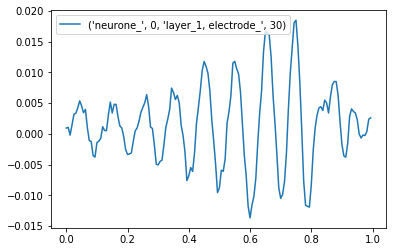

In [0]:
weights = np.array(model.get_weights()) #Convert the weights into np array

plot_weights(weights, electi)            #Plot the weights of the model

In [0]:
weights.shape

(2,)